# 고속도로 CCTV 데이터 기반 차량 인식

# 0. ENV

In [ ]:
# 가끔 아래의 에러가 발생할 경우 다음 코드를 실행한다.
# 로케일 에러
# NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
import os
import glob
import numpy as np
import torch

In [ ]:
# 경로 설정
HOME=os.getcwd()
print(HOME)

/home/jupyter


In [ ]:
!nvidia-smi

Fri Nov 24 00:46:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 300W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   

## ultralytics 다운로드 (8.0.20)
git clone과 pip install을 모두 실행함

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display, Image
display.clear_output()

import ultralytics
ultralytics.checks()

In [ ]:
# git clone method
%cd {HOME}
!git clone https://github.com/ultralytics/ultralytics
# %cd ultralytics

/home/jupyter
Cloning into 'ultralytics'...
remote: Enumerating objects: 19000, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 19000 (delta 120), reused 161 (delta 110), pack-reused 18816
Receiving objects: 100% (19000/19000), 10.27 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (13286/13286), done.
/home/jupyter/ultralytics


In [ ]:
!ls -al

# 1. DATA

## GCP BUCKET

### case1: 내 BUCKET에 있는 파일 다운로드

In [ ]:
# 내 프로젝트명 확인
!gcloud config list --format 'value(core.project)'

sessac-project-08-403700


In [ ]:
# 환경설정
# !PROJECT_ID='sessac-project-08-403700'
# !BUCKET="gs://highway-bucket"

# BUCKET 만들기
# !gsutil mb -l us-central1 $BUCKET

# 나의 BUCKET 리스트 보기
# !gsutil list

# BUCKET 안에 들어있는 파일 확인
# !gsutil ls -r $BUCKET

# hiway 폴더 만들고 거기로 이동
# !mkdir highway
# %cd highway/

# BUCKET -> 로컬로 파일 복사(=다운로드)
!gsutil -m cp gs://highway-bucket/dataset.zip .

### case2: 타인 BUCKET에 있는 파일 다운로드

사전에 bucket 소유자가 나의 서비스계정에 접근권한을 줘야함

In [ ]:
# 남의 BUCKET 확인
!gsutil ls -r gs://highway-data-bucket/

In [ ]:
# 남의 BUCKET -> 로컬로 파일 복사(=다운로드)
# highway 폴더 아래에 복사
!gsutil -m cp gs://highway-data-bucket/higiway-data-bucket.zip dataset.zip

# # 분할된 zip 파일
# !gsutil -m cp gs://highway-data-bucket/dataset.z01 highway/dataset.z01
# !gsutil -m cp gs://highway-data-bucket/dataset.z02 highway/dataset.z02
# !gsutil -m cp gs://highway-data-bucket/dataset.z03 highway/dataset.z03
# !gsutil -m cp gs://highway-data-bucket/dataset.z04 highway/dataset.z04
# !gsutil -m cp gs://highway-data-bucket/dataset.z05 highway/dataset.z05
# !gsutil -m cp gs://highway-data-bucket/dataset.z06 highway/dataset.z06
# !gsutil -m cp gs://highway-data-bucket/dataset.z07 highway/dataset.z07
# !gsutil -m cp gs://highway-data-bucket/dataset.z08 highway/dataset.z08

## zip 파일 압축풀기

### case1. 분할된 zip 파일 의 경우

시간 오래 걸리지만 손실 없음

In [ ]:
# !sudo apt-get install p7zip-full

In [ ]:
# method 1. 분할된 zip 파일을 바로 압축풀기
# 걸린 시간: 1시간 30분
# !7z x /home/jupyter/highway/dataset.zip

In [ ]:
# # method 2.  zip파일이 multi part로 구성되어있어서
# #             bad zipfile 에러때문에 다시 zip 복사 후 unzip 가능
# %cd {HOME}
# zipPath='/home/jupyter/highway/dataset.zip'

# # 2-1. zip 복사
# !zip -s- {zipPath} -O dataset.zip
# # 2-2. unzip
# %%time
# import zipfile
# import concurrent.futures
# zf = zipfile.ZipFile('/home/jupyter/dataset.zip')
# def unzip(file):
#     zf.extract(file)
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     executor.map(unzip, zf.infolist())

### case 2. 분할 안 된 zip 파일의 경우

제일 빠른 방법이지만 손실 가능성이 있으므로 데이터 개수 확인 필요!

In [ ]:
%%time
import zipfile
import multiprocessing
import concurrent.futures

def unzip(file):
    with lock:
        zf.extract(file, path='/home/jupyter')

zipfilePath = '/home/jupyter/highway_yolo.zip'  
zf = zipfile.ZipFile(zipfilePath)    

m = multiprocessing.Manager()
lock = m.Lock()

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 16.3 s, sys: 4.1 s, total: 20.4 s
Wall time: 5min 48s


In [ ]:
# 압축 풀 때 누락된 파일 다시 풀기 (-n 옵션: 중복 pass)
!unzip -n highway_yolo.zip

In [ ]:
# 용량을 위해 bucket에서 받아온 zip 지우기
# !rm -rf highway

## data structrue
```
dataset
├─ train
│ ├─ images
│ └─ labels
├─ validation
│ ├─ images
│ └─ labels
└─ data.yaml
```

In [ ]:
# dataset 경로 설정
dataPath = HOME+'/dataset'

In [ ]:
# train 개수 확인
a = glob.glob(dataPath+"/train/images/*")
b = glob.glob(dataPath+"/train/labels/*")
len(a), len(b)

In [ ]:
# valid 개수 확인
a = glob.glob(dataPath+"/valid/images/*")
b = glob.glob(dataPath+"/valid/labels/*")
len(a), len(b)

(3333, 3333)

## 레이블 시각화 하기

In [ ]:
from data_handling.draw_bounding_box import load_images, load_labels, plot_images


X_test = load_images(dataPath+"/train/images")
Y_test = load_labels(dataPath+"/train/labels")

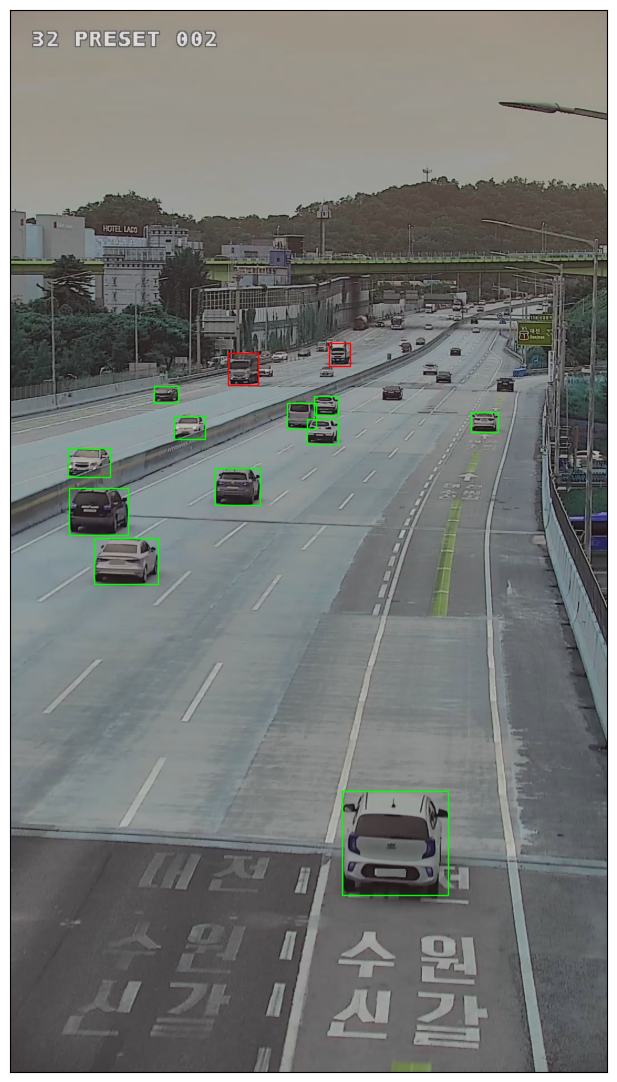

In [ ]:
plot_images(np.array([X_test[-1]]), np.array([Y_test[-1]]))

## 데이터셋 경로 설정하기

In [ ]:
import os
from glob import glob

trainPath = os.path.join(dataPath,'train')
validPath = os.path.join(dataPath,'val')
testPath  = os.path.join(dataPath,'test')

trainImagesPath = os.path.join(trainPath, 'images')
validImagesPath = os.path.join(validPath, 'images')
testImagesPath  = os.path.join(testPath,  'images')

trainLabelsPath = os.path.join(trainPath, 'labels')
validLabelsPath = os.path.join(validPath, 'labels')
testLabelsPath  = os.path.join(testPath,  'labels')

In [ ]:
trainImagesPath, trainLabelsPath

('/home/jupyter/dataset/train/images', '/home/jupyter/dataset/train/labels')

## Write data.yaml

In [ ]:
from IPython.core.magic import register_line_cell_magic

# yaml에 직접 쓰기를 실행하는 함수
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
dataPath

'/home/jupyter/dataset'

In [ ]:
dataYaml = os.path.join(dataPath,'data.yaml')
dataYaml

'/home/jupyter/dataset/data.yaml'

In [ ]:
print(trainImagesPath)
print(validImagesPath)
print(testImagesPath)

/home/jupyter/dataset/train/images
/home/jupyter/dataset/val/images
/home/jupyter/dataset/test/images


In [ ]:
%%writetemplate {dataYaml}
train: /home/jupyter/dataset/train/images
val: /home/jupyter/dataset/val/images

nc: 3
names: ['car', 'bus', 'truck']

# 2. Train Vehicle Detection Model

## check cuda

In [ ]:
!nvidia-smi

Fri Nov 24 04:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 300W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} \
    ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0+cu118     (Tesla V100-SXM2-16GB)


In [ ]:
# GPU cache 비우기
torch.cuda.empty_cache()

## n번째 GPU만 사용하고 싶은 경우

In [ ]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

## Model

In [49]:
!pwd

/home/jupyter


In [ ]:
# 에러메세지: AttributeError: 'FreeTypeFont' object has no attribute 'getsize'
# !pip install Pillow==9.5.0

### python ver
nano model

In [ ]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from YAML
#model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights
# model = YOLO(f'{HOME}/yolov8n.pt')    # 위 코드가 에러날 경우 사용

# Train the model
results = model.train(data=dataYaml, epochs=50, imgsz=800, device=[0,1,2,3], batch=72)

### CLI ver
xlarge model

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataYaml} epochs=100 device=0,1,2,3 batch=32 imgsz=800 plots=True cache=True

/home/jupyter
Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-2.0.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:1 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:2 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:3 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/jupyter/dataset/data.yaml, epochs=100, patience=50, batch=32, imgsz=800, save=True, save_period=-1, cache=True, device=(0, 1, 2, 3), workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, m

/home/jupyter


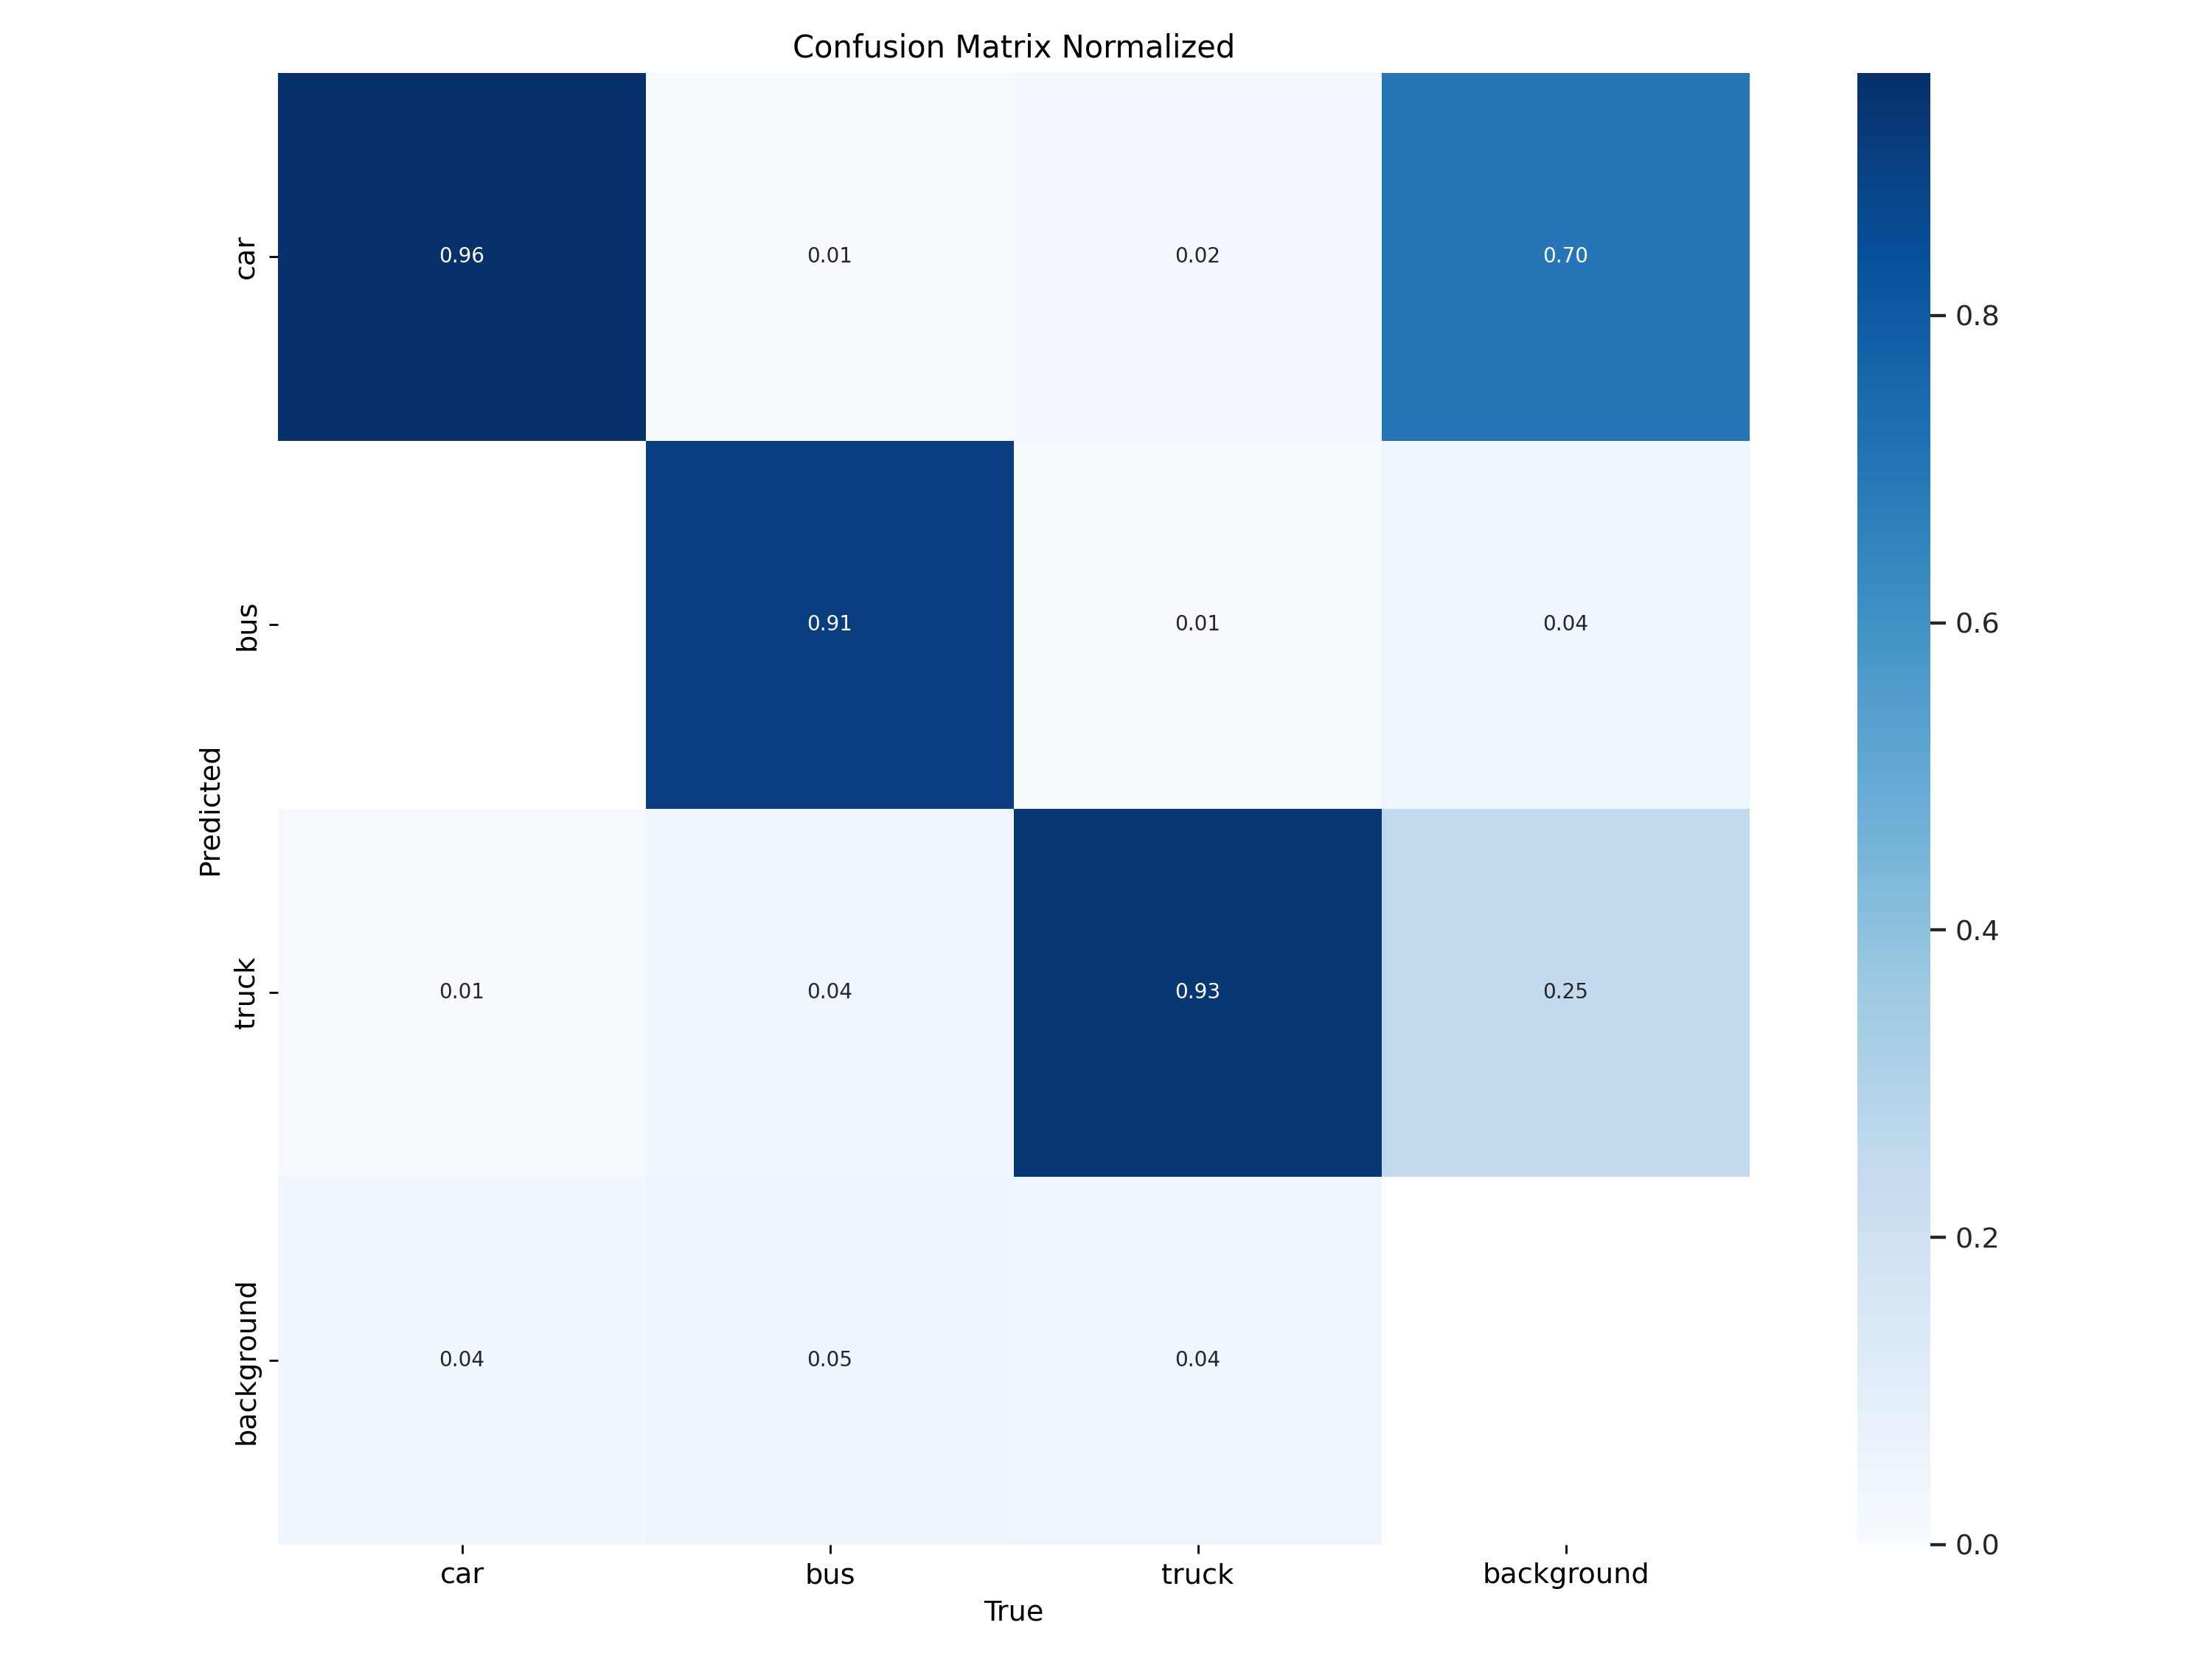

In [6]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix_normalized.png', width=800)

/home/jupyter


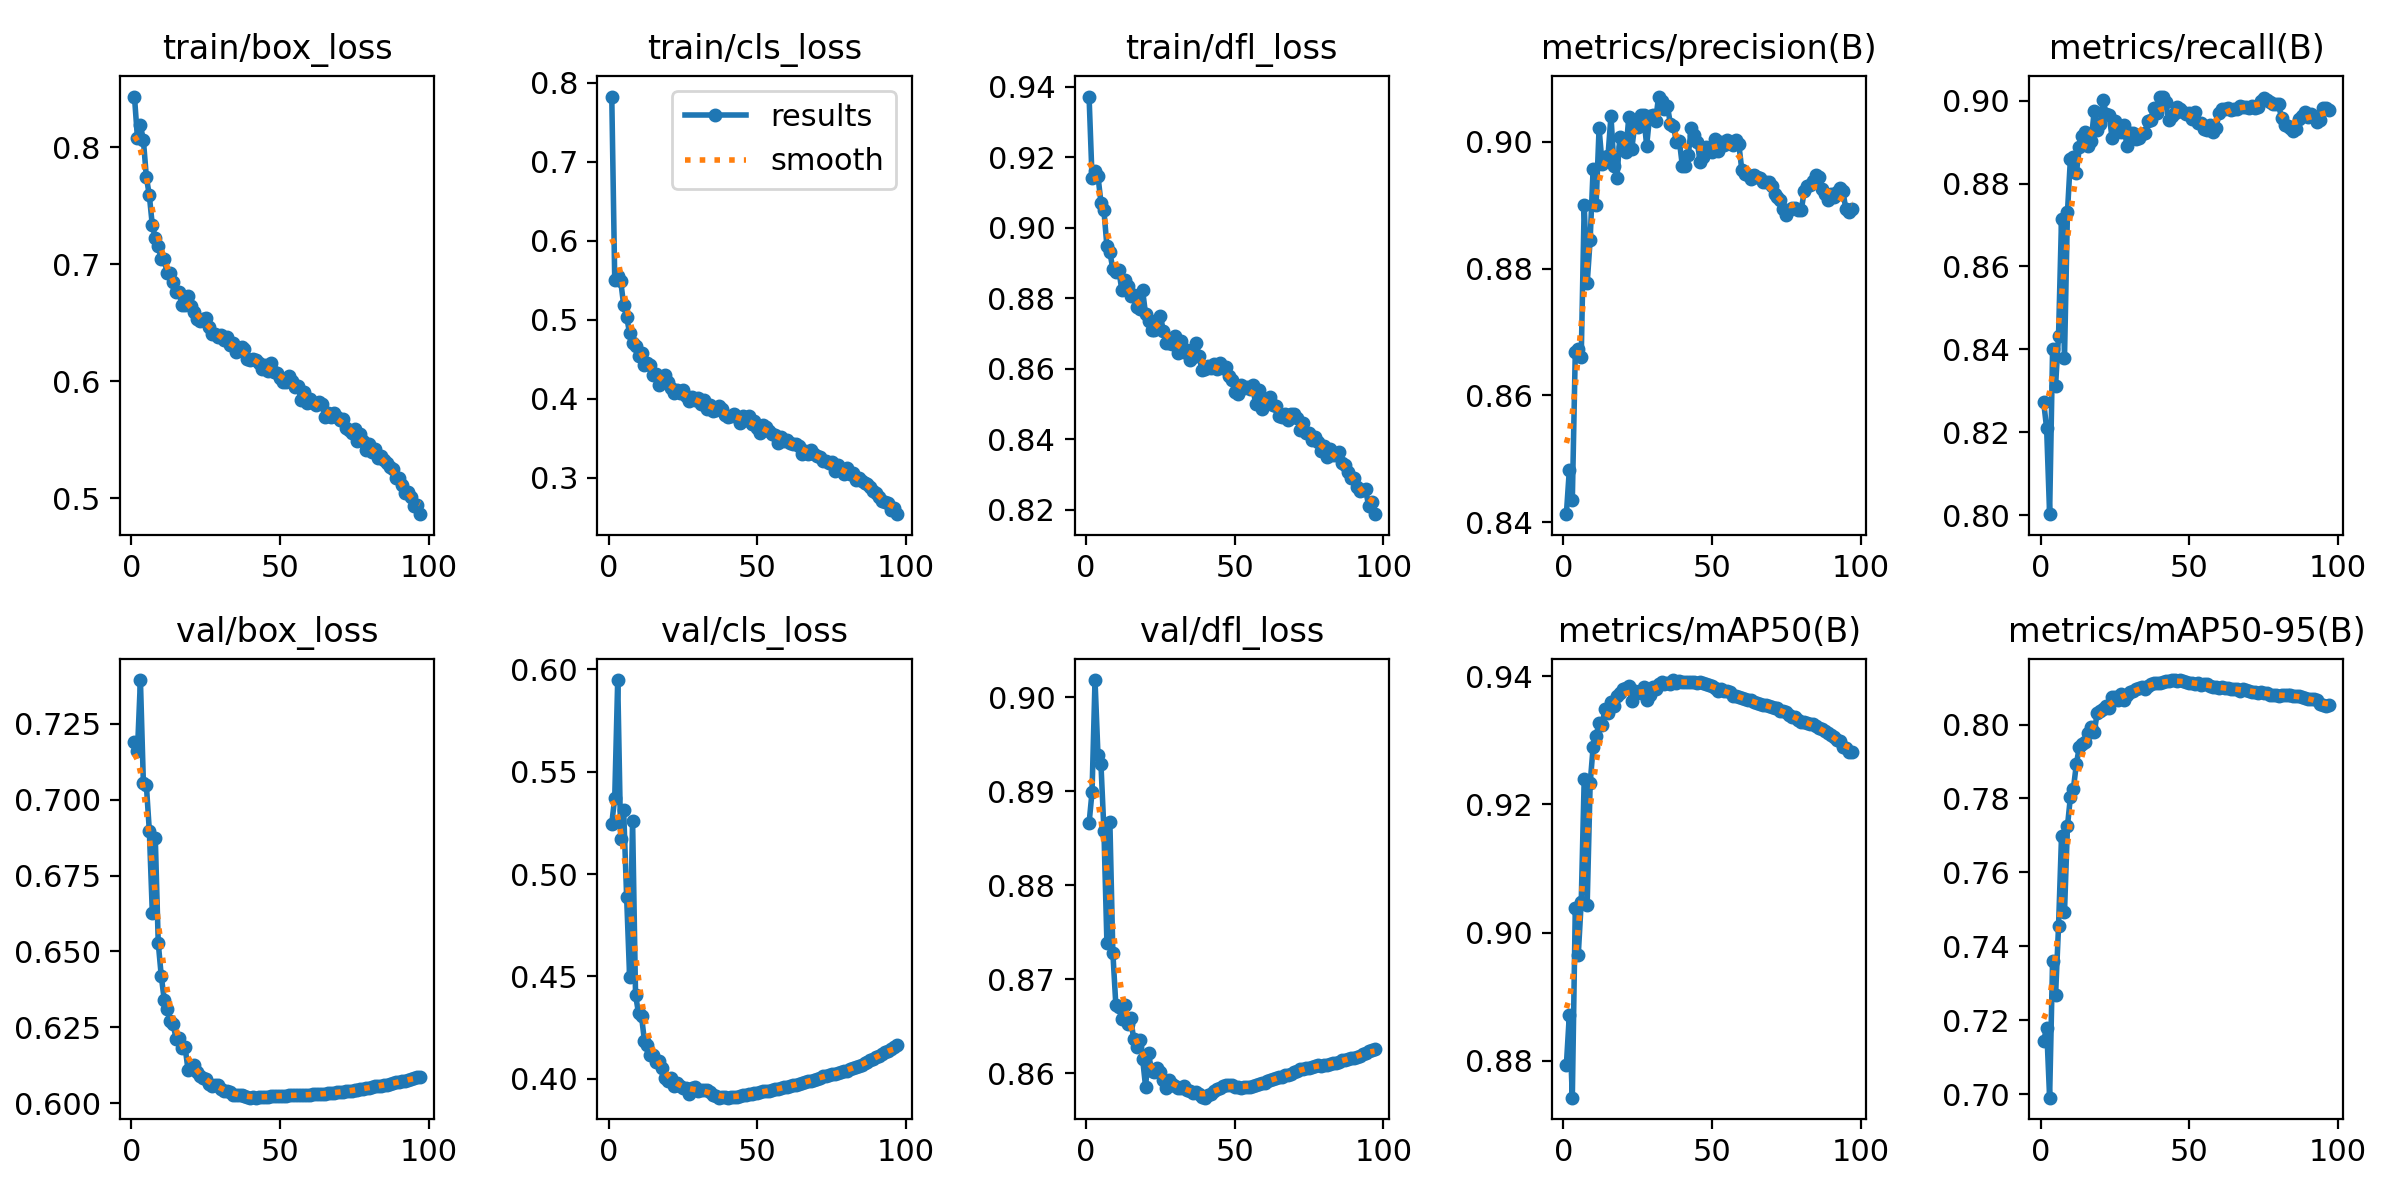

In [101]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/home/jupyter


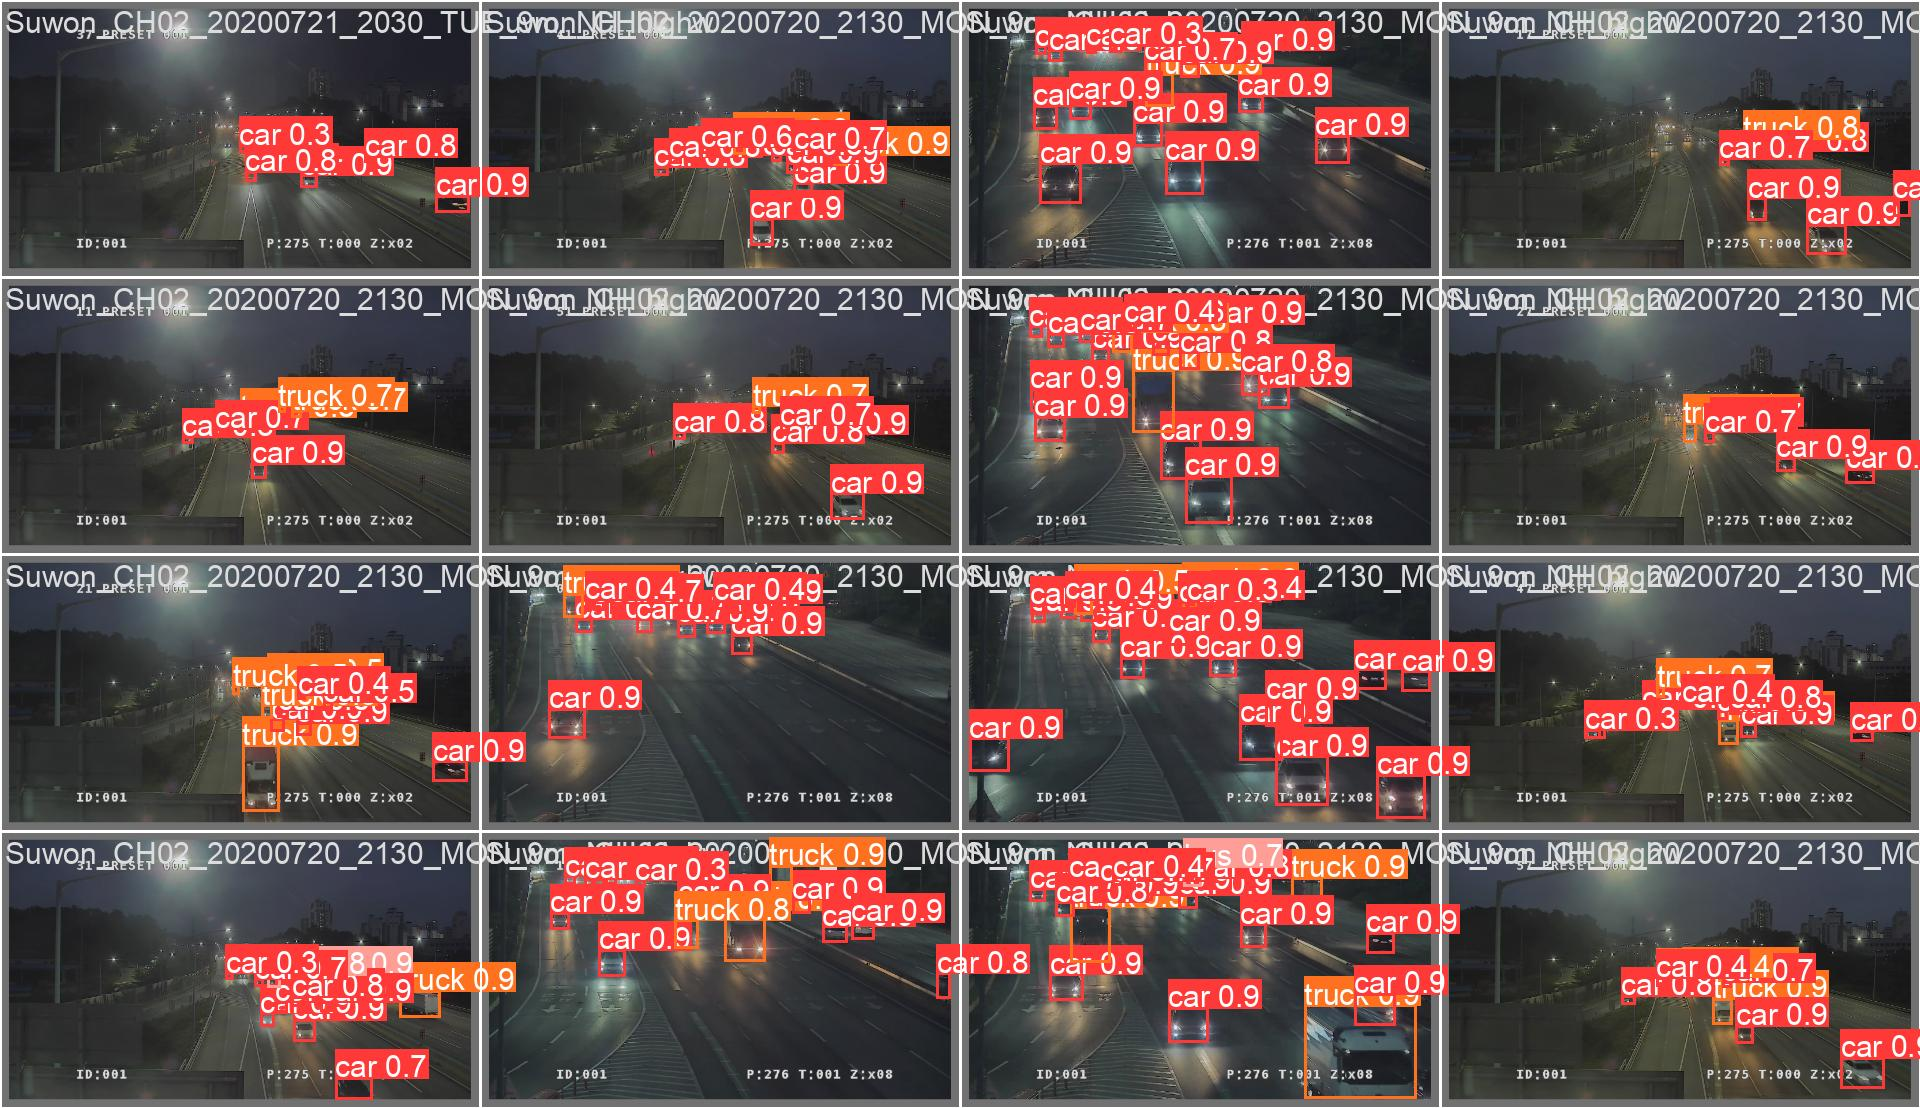

In [86]:
# 모델이 예측한 값
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=2000)

/home/jupyter


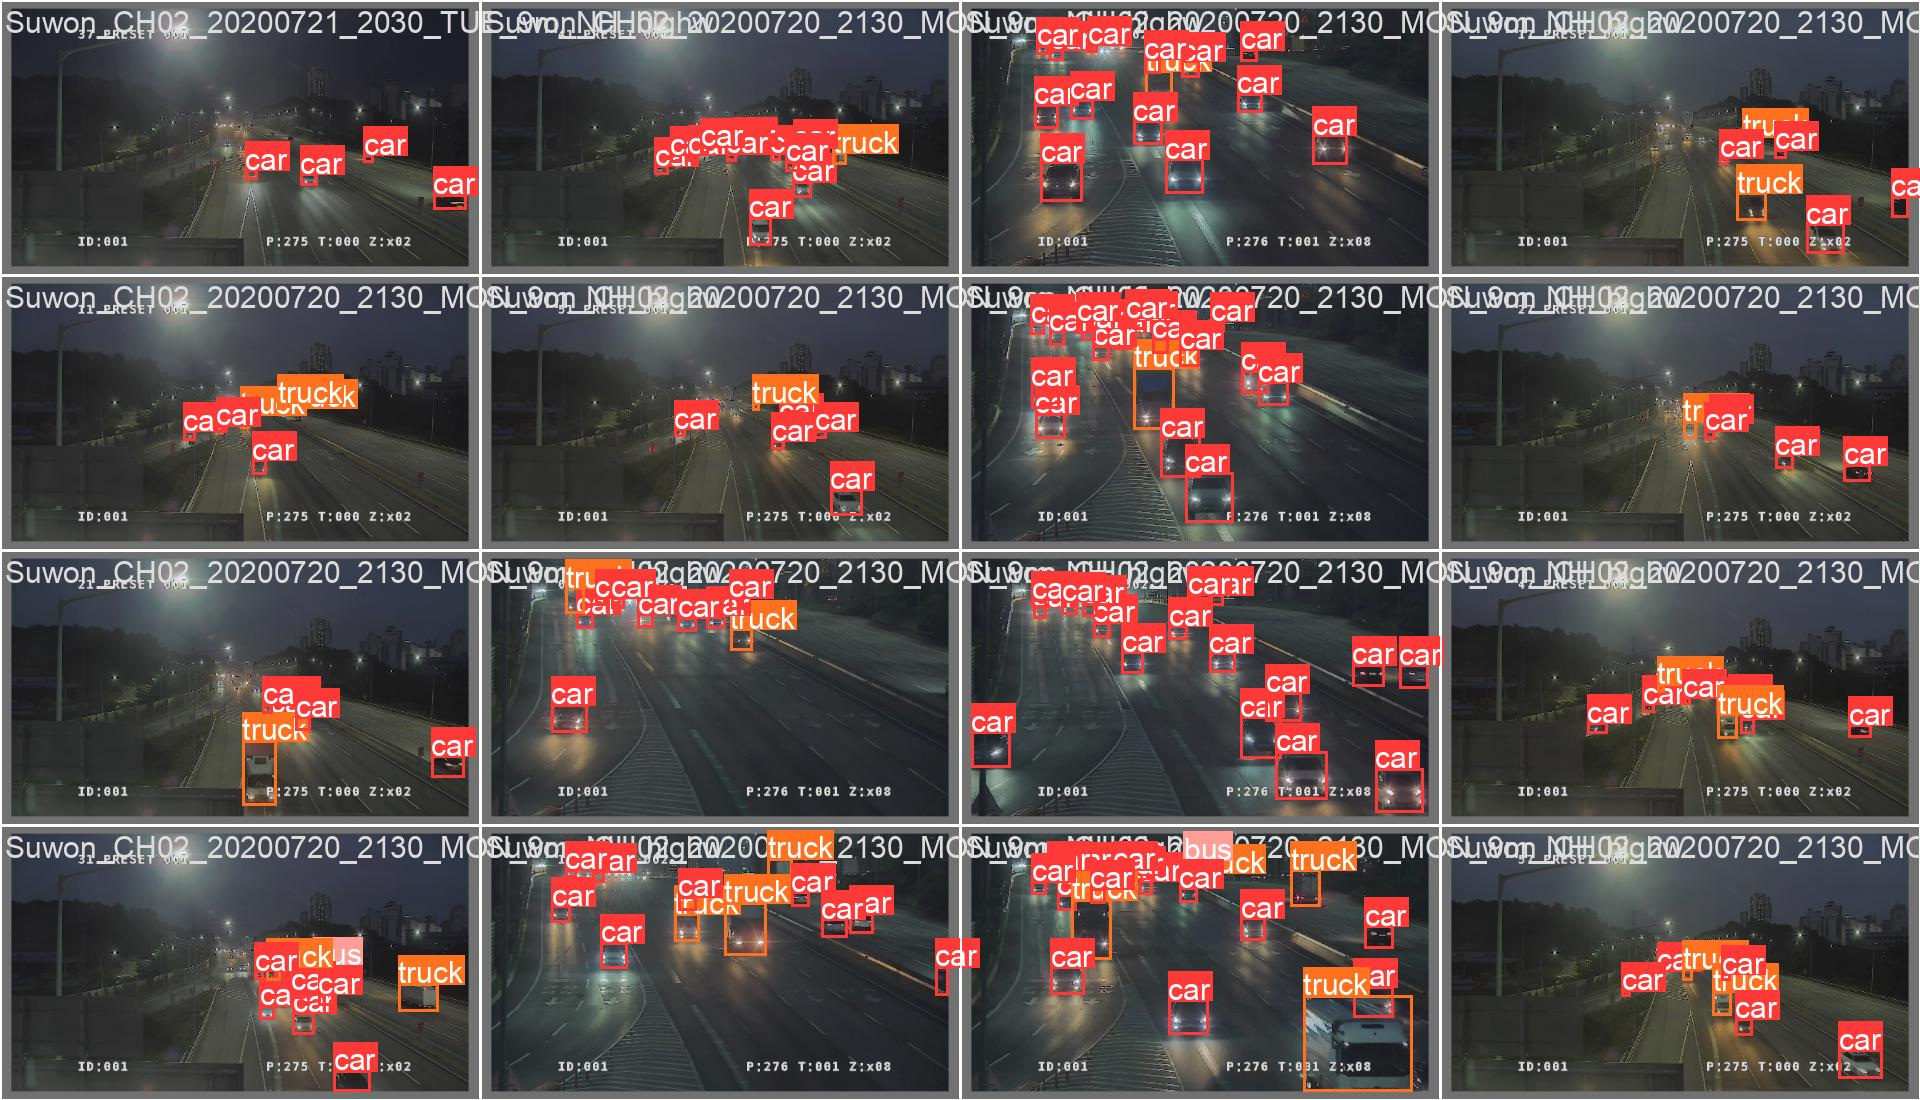

In [ ]:
# 정답값
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2_n_25epoch/val_batch0_labels.jpg', width=2000)

# 3. Validation

In [12]:
!yolo detect val model=runs/detect/train2/weights/best.pt data={dataYaml}

Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-2.0.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /home/jupyter/dataset/val/labels.cache... 3333 images, 103 backgro
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       3333      49993      0.897      0.898      0.939      0.814
                   car       3333      37999      0.925      0.923      0.965      0.849
                   bus       3333       1832      0.881      0.872      0.915      0.792
                 truck       3333      10162      0.884      0.898      0.937      0.801
Speed: 0.2ms preprocess, 14.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
# baseline
# !yolo detect val model=models/train_n25/weights/best.pt data={dataYaml} name="val_n25"
# best
# !yolo detect val model=models/train_back_x100/weights/best.pt data={dataYaml} name="val_back_x100"

# 4. Predict

## val images로 predict

In [92]:
testImages = f'{HOME}/dataset/val/images'
from glob import glob

testList =[]
for filename in glob(os.path.join(testImages, '*.png')):
    testList.append(filename)

In [96]:
testList = testList[:5]
testList

['/home/jupyter/dataset/val/images/Suwon_CH01_20201012_1723_MON_9m_RH_highway_TW5_sunny_FHD_039.png',
 '/home/jupyter/dataset/val/images/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_009.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20200722_1600_WED_9m_NH_highway_OW5_rainy_FHD_125.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20200722_1600_WED_9m_NH_highway_OW5_rainy_FHD_237.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20201010_1818_SAT_9m_RH_highway_OW5_sunny_FHD_064.png']

In [97]:
from ultralytics import YOLO

resultList =[]

# Load a pretrained YOLOv8n model
model = YOLO('/home/jupyter/runs/detect/train/weights/best.pt')

# Run inference on images
results = model(testList)

# View results
for result in results:
    resultList.append(result.cpu().numpy().boxes.cls)  # print the Boxes object containing the detection bounding boxes


0: 800x800 15 cars, 7 trucks, 1: 800x800 11 cars, 1 bus, 1 truck, 2: 800x800 11 cars, 5 trucks, 3: 800x800 6 cars, 1 bus, 1 truck, 4: 800x800 17 cars, 59.0ms
Speed: 4.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 800, 800)


In [98]:
import pandas as pd
sum = [0, 0, 0]

for result in resultList:
    for i in range(len(sum)):
        sum[i] += result.tolist().count(i)
print(sum)

print("전체 {}장의 이미지에서 승용차 {}대, 버스 {}대, 트럭 {}대를 발견하였습니다.".format(len(resultList), sum[0], sum[1], sum[2]))

[60, 2, 14]
전체 5장의 이미지에서 승용차 60대, 버스 2대, 트럭 14대를 발견하였습니다.


## 동영상으로 predict

In [ ]:
!yolo task=detect mode=predict model="C:\Users\SBA\Downloads\models\train_back_x100\weights\best.pt" conf=0.25 source="C:\Users\SBA\Videos\original.mp4" show=True

Ultralytics YOLOv8.0.218 🚀 Python-3.8.18 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i7-12700)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs

video 1/1 (1/1016) C:\Users\SBA\Videos\original.mp4: 448x800 6 cars, 5 trucks, 499.9ms
video 1/1 (2/1016) C:\Users\SBA\Videos\original.mp4: 448x800 6 cars, 5 trucks, 465.8ms
video 1/1 (3/1016) C:\Users\SBA\Videos\original.mp4: 448x800 6 cars, 5 trucks, 434.6ms
video 1/1 (4/1016) C:\Users\SBA\Videos\original.mp4: 448x800 6 cars, 5 trucks, 453.2ms
video 1/1 (5/1016) C:\Users\SBA\Videos\original.mp4: 448x800 6 cars, 5 trucks, 433.4ms
video 1/1 (6/1016) C:\Users\SBA\Videos\original.mp4: 448x800 4 cars, 6 trucks, 455.4ms
video 1/1 (7/1016) C:\Users\SBA\Videos\original.mp4: 448x800 5 cars, 5 trucks, 450.5ms
video 1/1 (8/1016) C:\Users\SBA\Videos\original.mp4: 448x800 5 cars, 5 trucks, 432.7ms
video 1/1 (9/1016) C:\Users\SBA\Videos\original.mp4: 448x800 5 cars, 5 trucks, 433.9ms
video 1/1 (10/1016) C:\Users\SBA\Video